# Enable Agent Tutorial Part 1: 이상치 탐지 모델 학습 (FDS)

## 개요

Fraud Detection System(FDS)을 위한 이상치 탐지 모델을 학습한다. 레이블(class)이 있지만 실제 사기 탐지 시스템에서는 정상 거래 데이터만으로 학습하고, 정상 패턴에서 벗어나는 거래를 이상치로 탐지하는 비지도 학습 방식이 효과적이다.

## 이상치 탐지 접근법의 장점

- 새로운 유형의 사기 패턴에도 대응 가능
- 클래스 불균형 문제 완화
- 레이블이 없는 데이터에도 적용 가능
- 실시간 탐지에 적합

## 학습 내용

- 거래 데이터 전처리 및 특성 엔지니어링
- Isolation Forest 모델 학습
- Autoencoder 모델 학습
- 앙상블 이상치 탐지 시스템 구축

---
## 1. 라이브러리 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch 버전: {torch.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

PyTorch 버전: 2.8.0
사용 디바이스: cpu


---
## 2. 데이터 로드 및 탐색

In [2]:
df = pd.read_csv('dataset/Fraud_Data.csv')

print(f"데이터셋 크기: {df.shape[0]:,}개 거래, {df.shape[1]}개 특성")
print()
df.head(10)

데이터셋 크기: 151,112개 거래, 11개 특성



,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


In [3]:
print("=== 데이터 타입 ===")
print(df.dtypes)
print()
print("=== 기초 통계량 ===")
df.describe()

=== 데이터 타입 ===
user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

=== 기초 통계량 ===


,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [4]:
fraud_count = df['class'].sum()
normal_count = len(df) - fraud_count
fraud_rate = fraud_count / len(df) * 100

print("=== 클래스 분포 ===")
print(f"정상 거래: {normal_count:,}건 ({100-fraud_rate:.2f}%)")
print(f"사기 거래: {fraud_count:,}건 ({fraud_rate:.2f}%)")
print(f"\n불균형 비율: 1:{normal_count//fraud_count}")

=== 클래스 분포 ===
정상 거래: 136,961건 (90.64%)
사기 거래: 14,151건 (9.36%)

불균형 비율: 1:9


---
## 3. 특성 엔지니어링

### 생성할 특성

- `time_diff_hours`: 가입부터 구매까지 소요 시간 (빠른 구매는 의심)
- `signup_hour`, `purchase_hour`: 시간대 (심야 거래 의심)
- `is_weekend`: 주말 거래 여부
- 범주형 변수 인코딩: source, browser, sex

In [5]:
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

# 가입-구매 시간 차이 (시간 단위)
df['time_diff_hours'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds() / 3600

# 시간대 특성
df['signup_hour'] = df['signup_time'].dt.hour
df['purchase_hour'] = df['purchase_time'].dt.hour

# 주말 여부
df['is_weekend'] = df['purchase_time'].dt.dayofweek.isin([5, 6]).astype(int)

# 심야 시간 여부 (00:00 ~ 06:00)
df['is_night'] = df['purchase_hour'].apply(lambda x: 1 if 0 <= x < 6 else 0)

print("시간 관련 특성 생성 완료")
df[['signup_time', 'purchase_time', 'time_diff_hours', 'signup_hour', 'purchase_hour', 'is_weekend', 'is_night']].head()

시간 관련 특성 생성 완료


,signup_time,purchase_time,time_diff_hours,signup_hour,purchase_hour,is_weekend,is_night
0,2015-02-24 22:55:49,2015-04-18 02:47:11,1251.856111,22,2,1,1
1,2015-06-07 20:39:50,2015-06-08 01:38:54,4.984444,20,1,0,1
2,2015-01-01 18:52:44,2015-01-01 18:52:45,0.000278,18,18,0,0
3,2015-04-28 21:13:25,2015-05-04 13:54:50,136.690278,21,13,0,0
4,2015-07-21 07:09:52,2015-09-09 18:40:53,1211.516944,7,18,0,0


In [6]:
# 범주형 변수 인코딩
label_encoders = {}

for col in ['source', 'browser', 'sex']:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"{col}: {dict(zip(le.classes_, range(len(le.classes_))))}")

print("\n범주형 변수 인코딩 완료")

source: {'Ads': 0, 'Direct': 1, 'SEO': 2}
browser: {'Chrome': 0, 'FireFox': 1, 'IE': 2, 'Opera': 3, 'Safari': 4}
sex: {'F': 0, 'M': 1}

범주형 변수 인코딩 완료


In [7]:
# 최종 특성 선택
feature_names = [
    'purchase_value',
    'age',
    'time_diff_hours',
    'signup_hour',
    'purchase_hour',
    'is_weekend',
    'is_night',
    'source_encoded',
    'browser_encoded',
    'sex_encoded'
]

X = df[feature_names].values
y = df['class'].values

print(f"최종 특성 수: {len(feature_names)}")
print(f"특성: {feature_names}")
print(f"X shape: {X.shape}")

최종 특성 수: 10
특성: ['purchase_value', 'age', 'time_diff_hours', 'signup_hour', 'purchase_hour', 'is_weekend', 'is_night', 'source_encoded', 'browser_encoded', 'sex_encoded']
X shape: (151112, 10)


---
## 4. 데이터 시각화

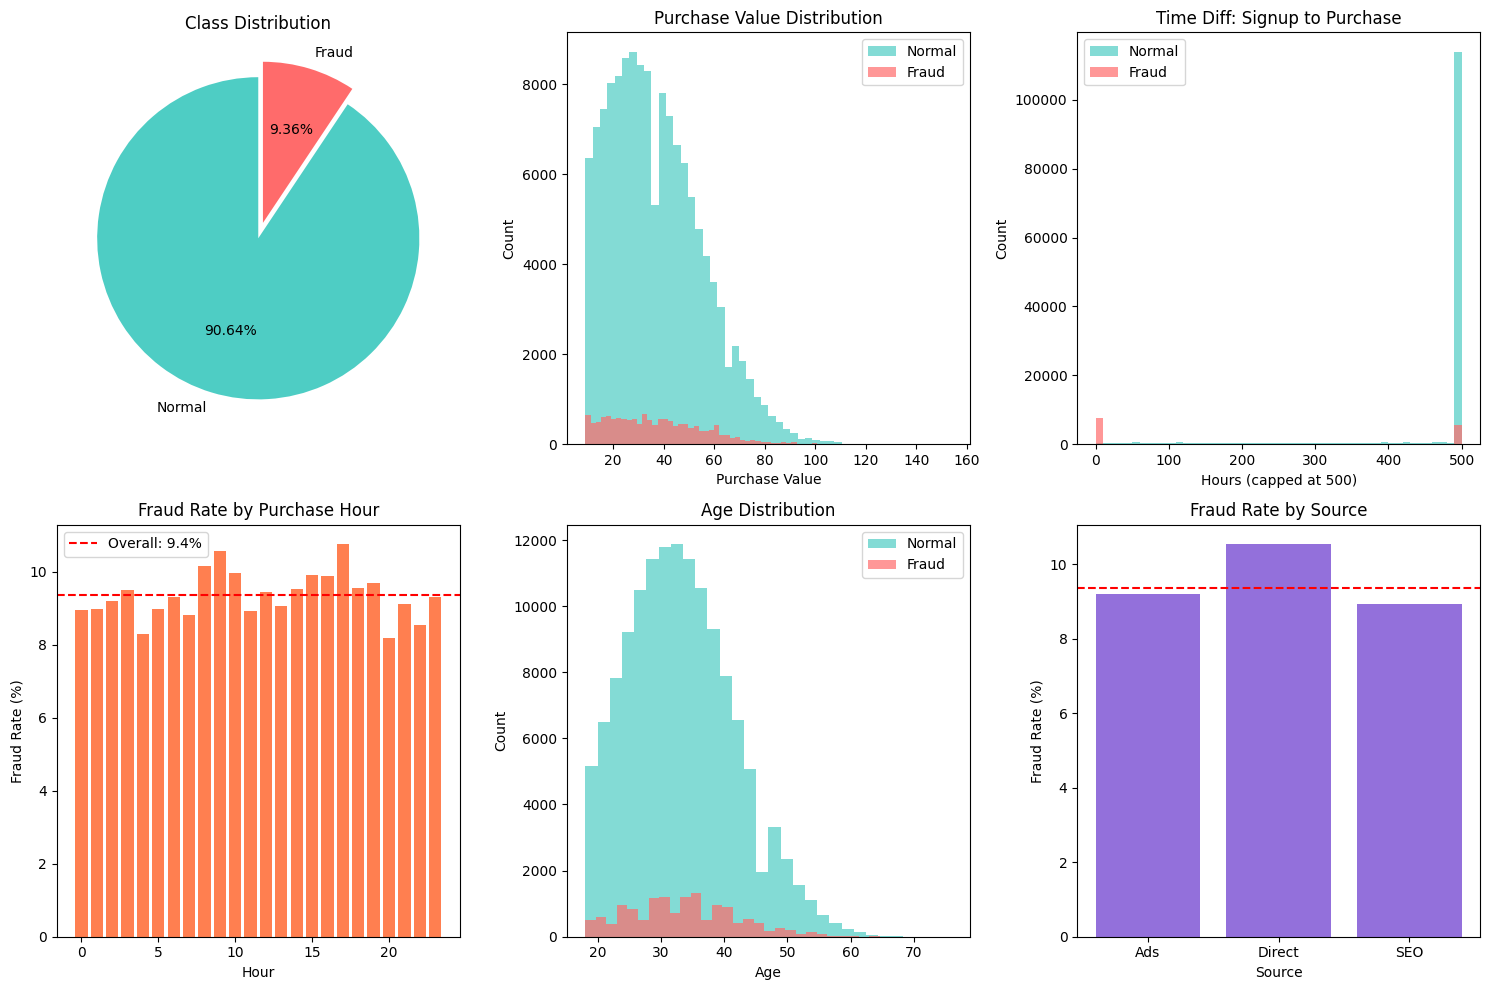

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 클래스 분포
ax = axes[0, 0]
colors = ['#4ecdc4', '#ff6b6b']
ax.pie([normal_count, fraud_count], labels=['Normal', 'Fraud'], 
       autopct='%1.2f%%', colors=colors, startangle=90, explode=[0, 0.1])
ax.set_title('Class Distribution')

# 구매 금액 분포
ax = axes[0, 1]
ax.hist(df[df['class']==0]['purchase_value'], bins=50, alpha=0.7, label='Normal', color='#4ecdc4')
ax.hist(df[df['class']==1]['purchase_value'], bins=50, alpha=0.7, label='Fraud', color='#ff6b6b')
ax.set_xlabel('Purchase Value')
ax.set_ylabel('Count')
ax.set_title('Purchase Value Distribution')
ax.legend()

# 가입-구매 시간 차이
ax = axes[0, 2]
ax.hist(df[df['class']==0]['time_diff_hours'].clip(upper=500), bins=50, alpha=0.7, label='Normal', color='#4ecdc4')
ax.hist(df[df['class']==1]['time_diff_hours'].clip(upper=500), bins=50, alpha=0.7, label='Fraud', color='#ff6b6b')
ax.set_xlabel('Hours (capped at 500)')
ax.set_ylabel('Count')
ax.set_title('Time Diff: Signup to Purchase')
ax.legend()

# 구매 시간대별 사기 비율
ax = axes[1, 0]
hourly_fraud = df.groupby('purchase_hour')['class'].mean() * 100
ax.bar(hourly_fraud.index, hourly_fraud.values, color='coral')
ax.set_xlabel('Hour')
ax.set_ylabel('Fraud Rate (%)')
ax.set_title('Fraud Rate by Purchase Hour')
ax.axhline(y=fraud_rate, color='red', linestyle='--', label=f'Overall: {fraud_rate:.1f}%')
ax.legend()

# 나이 분포
ax = axes[1, 1]
ax.hist(df[df['class']==0]['age'], bins=30, alpha=0.7, label='Normal', color='#4ecdc4')
ax.hist(df[df['class']==1]['age'], bins=30, alpha=0.7, label='Fraud', color='#ff6b6b')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.set_title('Age Distribution')
ax.legend()

# 소스별 사기 비율
ax = axes[1, 2]
source_fraud = df.groupby('source')['class'].mean() * 100
ax.bar(source_fraud.index, source_fraud.values, color='mediumpurple')
ax.set_xlabel('Source')
ax.set_ylabel('Fraud Rate (%)')
ax.set_title('Fraud Rate by Source')
ax.axhline(y=fraud_rate, color='red', linestyle='--')

plt.tight_layout()
plt.show()

In [9]:
# 빠른 구매 (1시간 이내) 분석
quick_purchase = df[df['time_diff_hours'] <= 1]
quick_fraud_rate = quick_purchase['class'].mean() * 100

print(f"=== 빠른 구매 (가입 후 1시간 이내) 분석 ===")
print(f"빠른 구매 건수: {len(quick_purchase):,}건")
print(f"빠른 구매 중 사기 비율: {quick_fraud_rate:.2f}%")
print(f"전체 사기 비율: {fraud_rate:.2f}%")
print(f"위험 배율: {quick_fraud_rate/fraud_rate:.1f}배")

=== 빠른 구매 (가입 후 1시간 이내) 분석 ===
빠른 구매 건수: 7,641건
빠른 구매 중 사기 비율: 99.52%
전체 사기 비율: 9.36%
위험 배율: 10.6배


---
## 5. 데이터 분할 및 정규화

### 이상치 탐지 학습 전략

- **학습 데이터**: 정상 거래만 사용 (이상치 탐지의 핵심)
- **검증/테스트**: 정상 + 사기 거래 포함 (성능 평가용)

In [10]:
# 전체 데이터 분할 (테스트 20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# 나머지에서 검증 20%
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_temp
)

# 학습용 정상 데이터만 추출
normal_mask = y_train_full == 0
X_train_normal = X_train_full[normal_mask]

print(f"학습 셋 (정상만): {X_train_normal.shape[0]:,}개")
print(f"검증 셋: {X_val.shape[0]:,}개 (사기: {y_val.sum():,}개)")
print(f"테스트 셋: {X_test.shape[0]:,}개 (사기: {y_test.sum():,}개)")

학습 셋 (정상만): 87,654개
검증 셋: 24,178개 (사기: 2,264개)
테스트 셋: 30,223개 (사기: 2,830개)


In [11]:
# 정규화 (정상 데이터 기준)
scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("정규화 완료 (정상 데이터 기준)")
print(f"평균: {X_train_normal_scaled.mean(axis=0).round(4)}")
print(f"표준편차: {X_train_normal_scaled.std(axis=0).round(4)}")

정규화 완료 (정상 데이터 기준)
평균: [-0. -0.  0. -0.  0. -0.  0. -0.  0.  0.]
표준편차: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


---
## 6. Isolation Forest 모델

### Isolation Forest 원리

```
정상 데이터: 밀집되어 있음 -> 고립시키려면 많은 분할 필요 -> 경로가 김
이상치 데이터: 떨어져 있음 -> 쉽게 고립됨 -> 경로가 짧음
```

- contamination: 예상되는 이상치 비율
- n_estimators: 트리 개수

In [12]:
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.1,  # 예상 이상치 비율 10%
    max_samples='auto',
    random_state=42,
    n_jobs=-1
)

print("Isolation Forest 학습 중...")
iso_forest.fit(X_train_normal_scaled)
print("Isolation Forest 학습 완료")

Isolation Forest 학습 중...
Isolation Forest 학습 완료


In [13]:
# 검증 셋 예측
# Isolation Forest: -1=이상치, 1=정상
val_pred_iso = iso_forest.predict(X_val_scaled)
val_scores_iso = -iso_forest.score_samples(X_val_scaled)  # 점수 반전 (높을수록 이상치)

# 예측 변환 (1=사기/이상치, 0=정상)
val_pred_iso_binary = (val_pred_iso == -1).astype(int)

print("=== Isolation Forest 검증 결과 ===")
print(classification_report(y_val, val_pred_iso_binary, target_names=['Normal', 'Fraud']))
print(f"AUC-ROC: {roc_auc_score(y_val, val_scores_iso):.4f}")

=== Isolation Forest 검증 결과 ===
              precision    recall  f1-score   support

      Normal       0.91      0.90      0.91     21914
       Fraud       0.16      0.18      0.17      2264

    accuracy                           0.83     24178
   macro avg       0.54      0.54      0.54     24178
weighted avg       0.84      0.83      0.84     24178

AUC-ROC: 0.5840


---
## 7. Autoencoder 모델

### Autoencoder 원리

```
Input(10) -> Encoder -> Latent(4) -> Decoder -> Output(10)

정상 데이터: 잘 복원됨 -> 복원 오차 낮음
이상치 데이터: 복원 어려움 -> 복원 오차 높음
```

In [14]:
class FraudAutoencoder(nn.Module):
    """이상치 탐지용 Autoencoder"""
    
    def __init__(self, input_dim=10, latent_dim=4):
        super(FraudAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed
    
    def get_reconstruction_error(self, x):
        with torch.no_grad():
            reconstructed = self.forward(x)
            error = torch.mean((x - reconstructed) ** 2, dim=1)
        return error

autoencoder = FraudAutoencoder(input_dim=10, latent_dim=4).to(device)
print(autoencoder)

FraudAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [15]:
# DataLoader 생성
batch_size = 256

train_tensor = torch.FloatTensor(X_train_normal_scaled)
train_dataset = TensorDataset(train_tensor, train_tensor)  # 입력=출력 (복원)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"학습 배치 수: {len(train_loader)}")

학습 배치 수: 343


In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5
)

num_epochs = 50
history = {'loss': []}

print("=== Autoencoder 학습 시작 ===")

for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0
    
    for batch_x, _ in train_loader:
        batch_x = batch_x.to(device)
        
        optimizer.zero_grad()
        reconstructed = autoencoder(batch_x)
        loss = criterion(reconstructed, batch_x)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    history['loss'].append(avg_loss)
    scheduler.step(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] Loss: {avg_loss:.6f}")

print("\nAutoencoder 학습 완료")

=== Autoencoder 학습 시작 ===
Epoch [ 10/50] Loss: 0.344369
Epoch [ 20/50] Loss: 0.324046
Epoch [ 30/50] Loss: 0.303890
Epoch [ 40/50] Loss: 0.302151
Epoch [ 50/50] Loss: 0.301200

Autoencoder 학습 완료


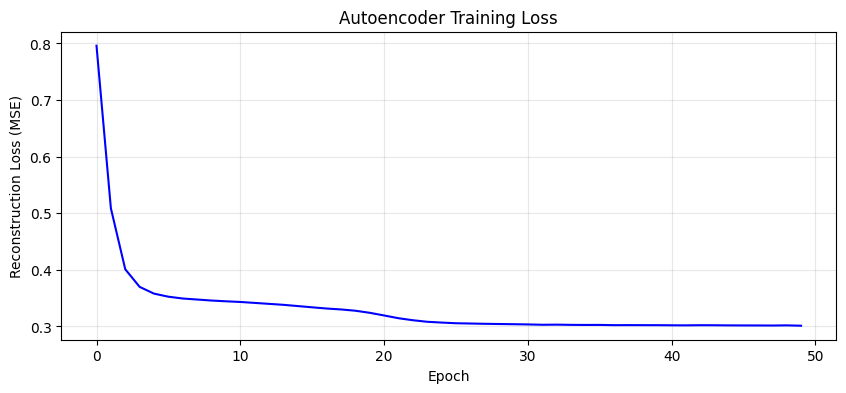

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(history['loss'], color='blue')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss (MSE)')
plt.title('Autoencoder Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
# 검증 셋 복원 오차 계산
autoencoder.eval()
val_tensor = torch.FloatTensor(X_val_scaled).to(device)
val_recon_errors = autoencoder.get_reconstruction_error(val_tensor).cpu().numpy()

# 임계값 설정 (정상 데이터의 95 퍼센타일)
train_tensor_gpu = torch.FloatTensor(X_train_normal_scaled).to(device)
train_recon_errors = autoencoder.get_reconstruction_error(train_tensor_gpu).cpu().numpy()
threshold_ae = np.percentile(train_recon_errors, 95)

print(f"Autoencoder 임계값 (95 percentile): {threshold_ae:.6f}")

# 예측
val_pred_ae = (val_recon_errors > threshold_ae).astype(int)

print("\n=== Autoencoder 검증 결과 ===")
print(classification_report(y_val, val_pred_ae, target_names=['Normal', 'Fraud']))
print(f"AUC-ROC: {roc_auc_score(y_val, val_recon_errors):.4f}")

Autoencoder 임계값 (95 percentile): 0.687530

=== Autoencoder 검증 결과 ===
              precision    recall  f1-score   support

      Normal       0.91      0.95      0.93     21914
       Fraud       0.16      0.10      0.12      2264

    accuracy                           0.87     24178
   macro avg       0.54      0.52      0.52     24178
weighted avg       0.84      0.87      0.85     24178

AUC-ROC: 0.5515


---
## 8. 앙상블 이상치 탐지

Isolation Forest와 Autoencoder의 점수를 결합하여 더 강건한 탐지 시스템을 구축한다.

In [19]:
# 점수 정규화 (0-1 범위)
def normalize_scores(scores):
    return (scores - scores.min()) / (scores.max() - scores.min())

val_scores_iso_norm = normalize_scores(val_scores_iso)
val_scores_ae_norm = normalize_scores(val_recon_errors)

# 앙상블 점수 (평균)
val_scores_ensemble = (val_scores_iso_norm + val_scores_ae_norm) / 2

print(f"Isolation Forest AUC: {roc_auc_score(y_val, val_scores_iso_norm):.4f}")
print(f"Autoencoder AUC: {roc_auc_score(y_val, val_scores_ae_norm):.4f}")
print(f"Ensemble AUC: {roc_auc_score(y_val, val_scores_ensemble):.4f}")

Isolation Forest AUC: 0.5840
Autoencoder AUC: 0.5515
Ensemble AUC: 0.5878


In [20]:
# 최적 임계값 찾기 (F1 기준)
precision, recall, thresholds = precision_recall_curve(y_val, val_scores_ensemble)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]

print(f"최적 임계값: {best_threshold:.4f}")
print(f"최적 F1 Score: {f1_scores[best_idx]:.4f}")

# 최적 임계값으로 예측
val_pred_ensemble = (val_scores_ensemble >= best_threshold).astype(int)

print("\n=== 앙상블 검증 결과 ===")
print(classification_report(y_val, val_pred_ensemble, target_names=['Normal', 'Fraud']))

최적 임계값: 0.3491
최적 F1 Score: 0.2056

=== 앙상블 검증 결과 ===
              precision    recall  f1-score   support

      Normal       0.92      0.82      0.87     21914
       Fraud       0.15      0.32      0.21      2264

    accuracy                           0.77     24178
   macro avg       0.54      0.57      0.54     24178
weighted avg       0.85      0.77      0.80     24178



---
## 9. 테스트 셋 최종 평가

In [21]:
# 테스트 셋 점수 계산
test_scores_iso = -iso_forest.score_samples(X_test_scaled)

test_tensor = torch.FloatTensor(X_test_scaled).to(device)
test_recon_errors = autoencoder.get_reconstruction_error(test_tensor).cpu().numpy()

# 정규화 및 앙상블
test_scores_iso_norm = normalize_scores(test_scores_iso)
test_scores_ae_norm = normalize_scores(test_recon_errors)
test_scores_ensemble = (test_scores_iso_norm + test_scores_ae_norm) / 2

# 예측
test_pred = (test_scores_ensemble >= best_threshold).astype(int)

print("=== 테스트 셋 최종 결과 ===")
print(classification_report(y_test, test_pred, target_names=['Normal', 'Fraud']))
print(f"\nAUC-ROC: {roc_auc_score(y_test, test_scores_ensemble):.4f}")

=== 테스트 셋 최종 결과 ===
              precision    recall  f1-score   support

      Normal       0.92      0.83      0.87     27393
       Fraud       0.14      0.26      0.18      2830

    accuracy                           0.78     30223
   macro avg       0.53      0.54      0.52     30223
weighted avg       0.84      0.78      0.81     30223


AUC-ROC: 0.5725


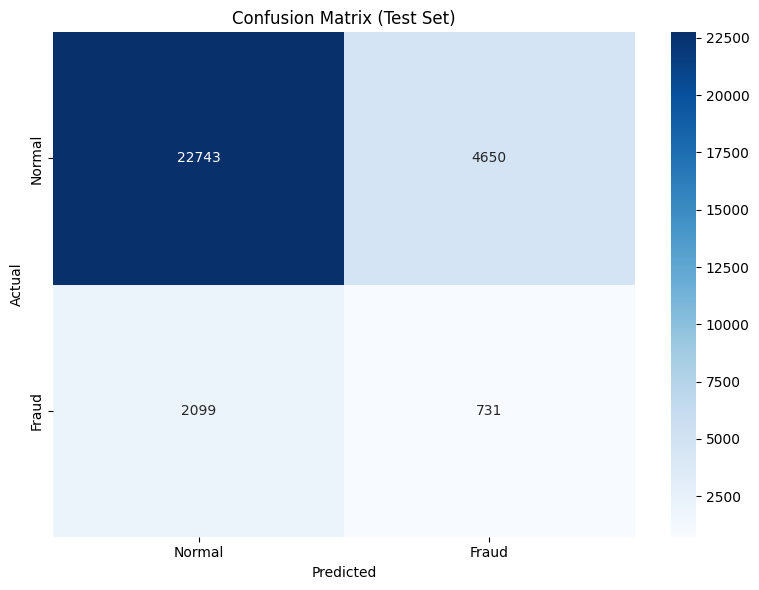

In [22]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

---
## 10. 모델 저장

In [23]:
Path('models').mkdir(exist_ok=True)

# Isolation Forest 저장
joblib.dump(iso_forest, 'models/isolation_forest.pkl')
print("Isolation Forest 저장 완료: models/isolation_forest.pkl")

# Autoencoder 저장
torch.save({
    'model_state_dict': autoencoder.state_dict(),
    'input_dim': 10,
    'latent_dim': 4,
    'threshold': float(threshold_ae)
}, 'models/autoencoder.pth')
print("Autoencoder 저장 완료: models/autoencoder.pth")

# 스케일러 저장
joblib.dump(scaler, 'models/fds_scaler.pkl')
print("스케일러 저장 완료: models/fds_scaler.pkl")

# 레이블 인코더 저장
joblib.dump(label_encoders, 'models/label_encoders.pkl')
print("레이블 인코더 저장 완료: models/label_encoders.pkl")

Isolation Forest 저장 완료: models/isolation_forest.pkl
Autoencoder 저장 완료: models/autoencoder.pth
스케일러 저장 완료: models/fds_scaler.pkl
레이블 인코더 저장 완료: models/label_encoders.pkl


In [24]:
# 메타데이터 저장
metadata = {
    'model_type': 'Ensemble Anomaly Detection (Isolation Forest + Autoencoder)',
    'feature_names': feature_names,
    'categorical_features': ['source', 'browser', 'sex'],
    'encoding_maps': {
        'source': dict(zip(label_encoders['source'].classes_.tolist(), range(len(label_encoders['source'].classes_)))),
        'browser': dict(zip(label_encoders['browser'].classes_.tolist(), range(len(label_encoders['browser'].classes_)))),
        'sex': dict(zip(label_encoders['sex'].classes_.tolist(), range(len(label_encoders['sex'].classes_))))
    },
    'ensemble_threshold': float(best_threshold),
    'autoencoder_threshold': float(threshold_ae),
    'test_auc_roc': float(roc_auc_score(y_test, test_scores_ensemble)),
    'training_samples': int(X_train_normal.shape[0]),
    'scaler_mean': scaler.mean_.tolist(),
    'scaler_scale': scaler.scale_.tolist(),
    'trained_at': datetime.now().isoformat()
}

with open('models/fds_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print("메타데이터 저장 완료: models/fds_metadata.json")
print()
print(json.dumps(metadata, indent=2, ensure_ascii=False))

메타데이터 저장 완료: models/fds_metadata.json

{
  "model_type": "Ensemble Anomaly Detection (Isolation Forest + Autoencoder)",
  "feature_names": [
    "purchase_value",
    "age",
    "time_diff_hours",
    "signup_hour",
    "purchase_hour",
    "is_weekend",
    "is_night",
    "source_encoded",
    "browser_encoded",
    "sex_encoded"
  ],
  "categorical_features": [
    "source",
    "browser",
    "sex"
  ],
  "encoding_maps": {
    "source": {
      "Ads": 0,
      "Direct": 1,
      "SEO": 2
    },
    "browser": {
      "Chrome": 0,
      "FireFox": 1,
      "IE": 2,
      "Opera": 3,
      "Safari": 4
    },
    "sex": {
      "F": 0,
      "M": 1
    }
  },
  "ensemble_threshold": 0.34911454311209955,
  "autoencoder_threshold": 0.6875302195549011,
  "test_auc_roc": 0.5725466089128803,
  "training_samples": 87654,
  "scaler_mean": [
    36.974969767494926,
    33.12559609373218,
    1445.4799379282917,
    11.49739886371415,
    11.520261482647683,
    0.2882127455678007,
    0.2481